# Overview
- スタッキングを試してみる 

# Import everything I need :)

In [78]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import lightgbm as lgb
from fastprogress import progress_bar

# Preparation

In [79]:
nb = 91
isSmallSet = False
length = 10000
model_name = 'lgb'

In [80]:
pd.set_option('display.max_columns', 200)

In [81]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/nb47_fc_train.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv',
 '../input/champs-scalar-coupling/nb29_fc_train_feature.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/nb47_fc_test.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupli

In [82]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)
    
type_train = train.type.values

In [83]:
# train
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path) [:length]
else:
    test = pd.read_csv(path)
    
type_test = test.type.values

## myFunc
**metrics**

In [84]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

# Stacking

In [89]:
path_list = [
'nb54_{}_random_forest_regressor_-1.45569.csv',
'nb60_{}_lgb_-1.5330660525700779.csv',
'nb79_{}_extra_trees_regressor_-1.56760.csv',
'nb80_{}_extra_trees_regressor_-1.48000.csv',
'nb81_{}_bagging_regressor_-1.44452.csv',
'nb84_{}_extra_trees_regressor_-1.60943.csv',
'nb85_{}_extra_trees_regressor_-1.52972.csv',
'nb88_{}_lgb_-1.547953965914086.csv',
'nb91_{}_extra_trees_regressor_-1.47467.csv',
]

In [90]:
# oof
oofs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('oof'))[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('oof'))
    oofs.append(df)

In [91]:
# sub
subs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)
    subs.append(df)

# Create train, test data

LabelEncode
- `type`   = {2JHC, ...}

In [92]:
lbl = LabelEncoder()
lbl.fit(list(type_train) + list(type_test))
type_train_lbl = lbl.transform(type_train)
type_test_lbl = lbl.transform(type_test)

In [93]:
y = train.scalar_coupling_constant
X = pd.concat(oofs, axis=1)
X = pd.DataFrame(X.values, columns=path_list)
X_test = pd.concat(subs, axis=1)
X_test = pd.DataFrame(X_test.values, columns=path_list)

# Training model

**params**

In [94]:
# Configuration
TARGET = 'scalar_coupling_constant'
CAT_FEATS = []
N_ESTIMATORS = 1500
VERBOSE = 100
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error
LEANING_RATE = 0.01 
N_JOBS = 5

# lightgbm params from nb55
# lgb_params = {'num_leaves': 128,
#           'min_child_samples': 79,
#           'objective': 'regression',
#           'max_depth': 9,
#           'learning_rate': 0.2,
#           "boosting_type": "gbdt",
#           "subsample_freq": 1,
#           "subsample": 0.9,
#           "bagging_seed": 11,
#           "metric": 'mae',
#           "verbosity": -1,
#           'reg_alpha': 0.1,
#           'reg_lambda': 0.3,
#           'colsample_bytree': 1.0
#          }

lgb_params_list =  [
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 1,
  'max_depth': 8,
  'metric': 'mae',
  'min_child_samples': 70,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.1,
  'reg_lambda': 0.6,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.8,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 70,
  'num_leaves': 100,
  'objective': 'regression',
  'reg_alpha': 0.4,
  'reg_lambda': 0.4,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.8,
  'max_depth': 8,
  'metric': 'mae',
  'min_child_samples': 45,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.6,
  'reg_lambda': 0.4,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 1,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 20,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.2,
  'reg_lambda': 0.4,
  'subsample': 0.3,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.8,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 70,
  'num_leaves': 100,
  'objective': 'regression',
  'reg_alpha': 0.1,
  'reg_lambda': 0.2,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 1,
  'max_depth': 8,
  'metric': 'mae',
  'min_child_samples': 20,
  'num_leaves': 100,
  'objective': 'regression',
  'reg_alpha': 0.6,
  'reg_lambda': 0.2,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.6,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 100,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.2,
  'reg_lambda': 0.4,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 1,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 45,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.2,
  'reg_lambda': 0.2,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1}]

In [95]:
# init

def train_lgb(X, X_test, y, lgb_params, folds,
              verbose, early_stopping_rounds, n_estimators, categorical_feature=None):

    result_dict = {}
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    models = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print('------------------')
        print(f'- fold{fold_n + 1}' )
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        

        # Train the model
        model = lgb.LGBMRegressor(**lgb_params, n_estimators=n_estimators, n_jobs=N_JOBS, learning_rate=LEANING_RATE)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds,
                  categorical_feature=CAT_FEATS)

        # predict
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)   
        y_test_pred = model.predict(X_test)

        oof[valid_idx] = y_valid_pred.reshape(-1,)  # oof: out of folds
        scores.append(mean_absolute_error(y_valid, y_valid_pred))

        prediction += y_test_pred

        # feature_importance
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = X.columns
        fold_importance['importance'] = model.feature_importances_
        fold_importance['fold'] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    # result
    prediction /= folds.n_splits
    feature_importance["importance"] /= folds.n_splits
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['feature_importance'] = feature_importance


    print('------------------')
    print('====== finish ======')
    print('score list:', scores)
    X['scalar_coupling_constant'] = y
#     cv_score = kaggle_metric(X, oof)
    cv_score = np.log(mean_absolute_error(y, oof))  # kaggle_metric(X, oof)
#     X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
    print('CV mean score(group log mae): {0:.4f}'.format(cv_score))
    print('')

    
    return result_dict, cv_score

In [96]:
n_folds = 6
folds = KFold(n_splits=n_folds, shuffle=True)

In [97]:
%%time
# type ごとの学習 

feature_importance  = pd.DataFrame()
X_short = pd.DataFrame({'ind': list(X.index), 'type': type_train, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': type_test, 'prediction': [0] * len(X_test)})
for i, t in enumerate(np.unique(type_train)):
    print('*'*80)
    print(f'Training of type {t}')
    print('*'*80)
    idx = lbl.transform([t])[0]
    lgb_params = lgb_params_list[idx]
    X_t = X.loc[type_train == t]
    X_test_t = X_test.loc[type_test == t]
    y_t = X_short.loc[type_train == t, 'target'].values
#     from IPython.core.debugger import Pdb; Pdb().set_trace()

#     result_dict_lgb3 = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=3000)
    result_dict, cv_score = train_lgb(X=X_t, X_test=X_test_t, y=y_t, folds=folds, lgb_params=lgb_params,
                            verbose=VERBOSE, early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                            n_estimators=N_ESTIMATORS,
                            categorical_feature=CAT_FEATS)
    X_short.loc[type_train == t, 'oof'] = result_dict['oof']
    X_short_test.loc[type_test == t, 'prediction'] = result_dict['prediction']
    
    feature_importance = pd.concat([feature_importance, result_dict['feature_importance']], axis=0)
    
print('')
print('===== finish =====')
X['scalar_coupling_constant'] = y
X['type'] = type_train
metric = kaggle_metric(X, X_short['oof'])
X = X.drop(['scalar_coupling_constant', 'prediction', 'type'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(metric))
prediction = X_short_test['prediction']

********************************************************************************
Training of type 1JHC
********************************************************************************
------------------
- fold1
Fold 1 started at Tue Aug 27 09:56:52 2019
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 4.71675	valid_1's l1: 4.72898
[200]	training's l1: 1.84403	valid_1's l1: 1.85088
[300]	training's l1: 0.905292	valid_1's l1: 0.912504
[400]	training's l1: 0.6567	valid_1's l1: 0.664637
[500]	training's l1: 0.606725	valid_1's l1: 0.615328
[600]	training's l1: 0.598957	valid_1's l1: 0.608006
[700]	training's l1: 0.597633	valid_1's l1: 0.607084
[800]	training's l1: 0.597311	valid_1's l1: 0.60702
[900]	training's l1: 0.59711	valid_1's l1: 0.607006
[1000]	training's l1: 0.596767	valid_1's l1: 0.606862
[1100]	training's l1: 0.596469	valid_1's l1: 0.606762
[1200]	training's l1: 0.5962	valid_1's l1: 0.606679
[1300]	training's l1: 0.595956	valid_1's l1: 0.606594


## plot feature importance

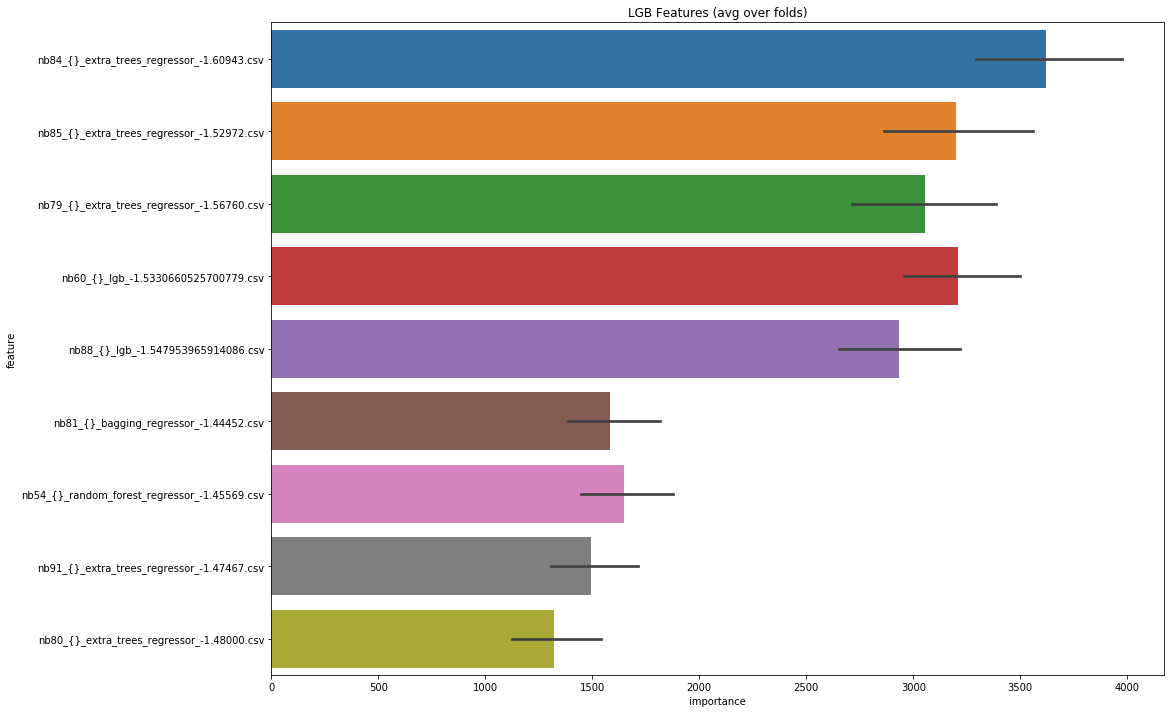

In [98]:
# top 50 features
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

# Save

**submission**

In [99]:
# path_submittion = './output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path_submittion = '../output/nb{}_stack_submission_lgb_{}.csv'.format(nb, metric)
print(f'save pash: {path_submittion}')

save pash: ../output/nb91_stack_submission_lgb_-1.7348780297791941.csv


In [100]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[::100]
if isSmallSet:
    pass
else:
    submittion['scalar_coupling_constant'] = prediction
    submittion.to_csv(path_submittion, index=False)

---
**result**

In [101]:
path_oof = '../output/' + 'nb{}_stack_oof_lgb_{}.csv'.format(nb, metric)
print(f'save pash: {path_oof}')

save pash: ../output/nb91_stack_oof_lgb_-1.7348780297791941.csv


In [102]:
oof = pd.DataFrame(X_short['oof'])
if isSmallSet:
    pass
else:
    oof.to_csv(path_oof, index=False)

# analysis

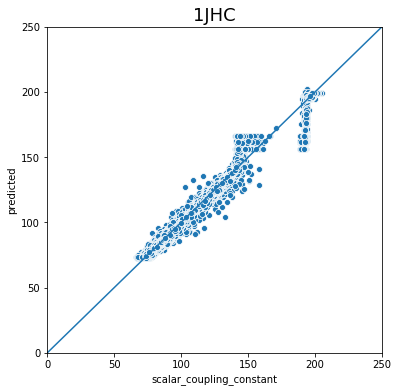

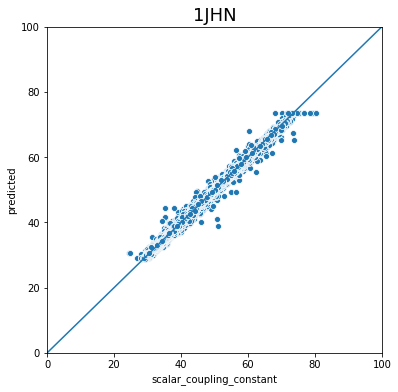

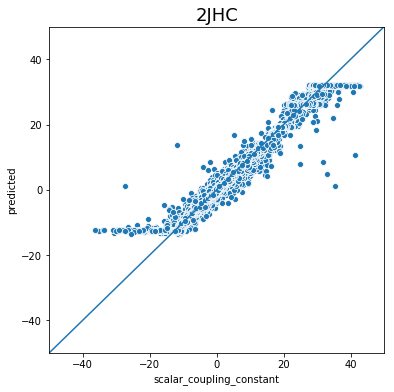

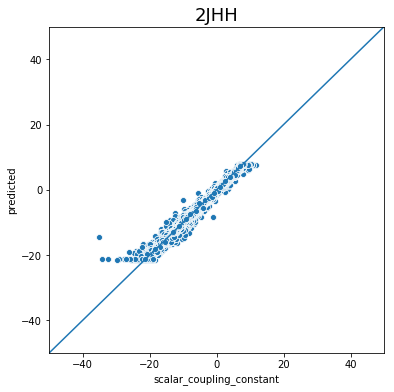

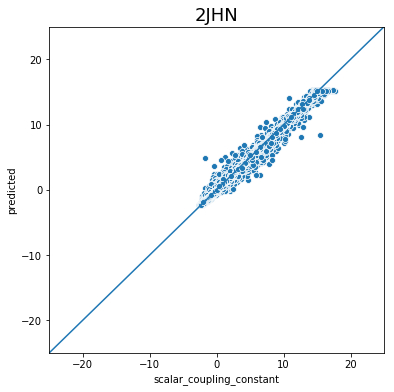

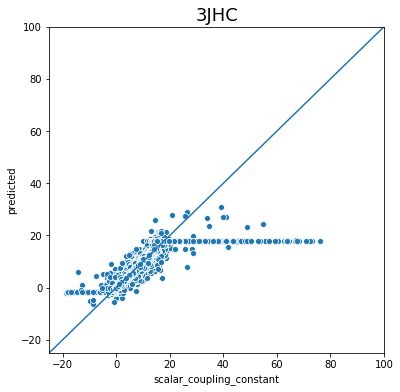

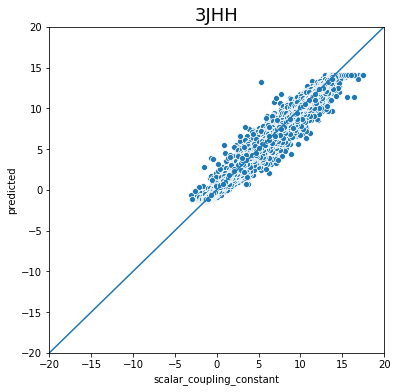

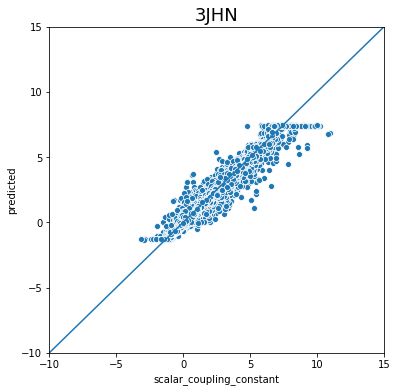

In [103]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof'].values
plot_data['type'] = type_train

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)